The very first attampt to use QuantLib and BS model and generate a call price.
stock_price is stored in quote so we can change the value later.

In [1]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer


# option data
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(170.0)
strike_price = 150
volatility = ql.SimpleQuote(0.10) # the historical vols for a year
dividend_rate =  ql.SimpleQuote(0.002)
risk_free_rate = ql.SimpleQuote(0.003)
option_type = ql.Option.Call

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(27, 10, 2019)
ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(risk_free_rate), day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(dividend_rate), day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, ql.QuoteHandle(volatility), day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


Analytic Black-Scholes calculation:

In [2]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
time_bs_start = timer()
bs_price = european_option.NPV()
delta = european_option.delta()
gamma = european_option.gamma() #second order
vega = european_option.vega()
rho = european_option.rho()
theta = european_option.theta()
time_bs_end = timer()
time_bs = time_bs_end - time_bs_start


print("The theoretical price is ", bs_price)
print("The delta is ", delta)#Change in underlying price
print("The gamma is ", gamma)#second order: rate of change in price
print("The vega is ", vega)#Change in volatility
print("The rho is ", rho)#Change in interest rate
print("The theta is ", theta)#Change in time to expiration
print("Time used for BS calculation in total is ", time_bs)


The theoretical price is  20.912114216635807
The delta is  0.9022541582733737
The gamma is  0.009938484700038275
The vega is  29.03698484648708
The rho is  133.9228306919182
The theta is  -1.5267579034120837
Time used for BS calculation in total is  0.003004504999999824


In [3]:
#prepare for plotting
xs_bs = np.linspace(100, 200, 400)
ys_bs = []
for x in xs_bs:
    stock_price.setValue(x)
    ys_bs.append(european_option.NPV())

Instead of using analytic Black-Scholes formula, we can use Monte-Carlo simulation, output the price and the Greeks.

In [4]:
stock_price.setValue(170)
engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                      timeSteps=20,
                                      requiredSamples=250000)
european_option.setPricingEngine(engine)

time_mc_start = timer()
bs_price = european_option.NPV()
error = european_option.errorEstimate()
print("The monte carlo theoretical price is ", bs_price)
print("The monte carlo error is ", error)

#The Greeks for Monte-Carlo
p_original = bs_price
original_price = stock_price.value()
change_stock_price = 0.1
stock_price.setValue(original_price + change_stock_price)
p_plus = european_option.NPV()
print('price plus: ', p_plus)
stock_price.setValue(original_price - change_stock_price)
p_minus = european_option.NPV()
print('price minus: ', p_minus)
stock_price.setValue(original_price)
mc_delta = (p_plus - p_minus) / (2*change_stock_price)
mc_gamma = (p_plus - 2*original_price + p_minus) /(change_stock_price*change_stock_price)
print("delta in MC is: ", mc_delta)
print("gamma in MC is: ", mc_gamma)

change_r = 0.001
original_r = risk_free_rate.value()
risk_free_rate.setValue(original_r + change_r)
p_plus = european_option.NPV()
risk_free_rate.setValue(original_r)
mc_rho = (p_plus - p_original) / change_r
print("rho in MC is: ", mc_rho)

change_sigma = 0.001
original_sigma = volatility.value()
volatility.setValue(original_sigma + change_sigma)
p_plus = european_option.NPV()
volatility.setValue(original_sigma)
mc_vega = (p_plus - p_original) / change_sigma
print("vega in MC is: ", mc_vega)

ql.Settings.instance().evaluationDate = calculation_date + 1
p_later = european_option.NPV()
change_in_time = 1.0 / 365
mc_thema = (p_later - p_original) / change_in_time
print("thema in MC is: ", mc_thema)

time_mc_end = timer()
time_mc = time_mc_end - time_mc_start

print("Time used for MC calculation in total is ", time_mc, ' seconds')


The monte carlo theoretical price is  20.93312784649986
The monte carlo error is  0.03166101928065828
price plus:  21.053961963631025
price minus:  20.828700329809084
delta in MC is:  1.126308169109702
gamma in MC is:  -29811.733770655985
rho in MC is:  118.84876232008779
vega in MC is:  -24.53558067367112
thema in MC is:  -0.44142266317644285
Time used for MC calculation in total is  8.431576100000001  seconds


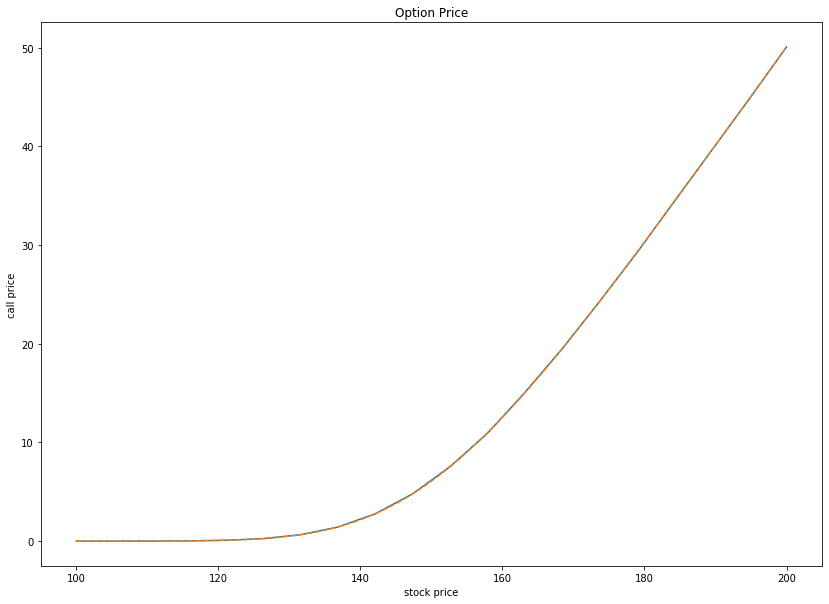

In [5]:
%matplotlib inline
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

xs = np.linspace(100, 200, 20)
ys = []
for x in xs:
    stock_price.setValue(x)
    ys.append(european_option.NPV())
    
plt.figure(figsize=(14,10))
plt.plot(xs, ys)
plt.plot(xs_bs, ys_bs, linestyle='dashed')
plt.xlabel('stock price') 
plt.ylabel('call price') 
plt.title('Option Price') 
plt.show() 

An Option Class which stores all the options info; return BS model call price; return the wanted data set for training purpose.

In [3]:
import numpy as np
from timeit import default_timer as timer

class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        self.mc_price = -1

    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def BSM_Greeks(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        time_bs_start = timer()
        bs_price = european_option.NPV()
        delta = european_option.delta()
        gamma = european_option.gamma() #second order
        vega = european_option.vega()
        rho = european_option.rho()
        theta = european_option.theta()
        time_bs_end = timer()
        time_bs = time_bs_end - time_bs_start
        print("Delta is ", delta)#Change in underlying price
        print("Gamma is ", gamma)#second order: rate of change in price
        print("Tho is ", rho)#Change in interest rate
        print("Vega is ", vega)#Change in volatility
        print("Theta is ", theta)#Change in time to expiration
        print("Time used for BS calculation in total is ", time_bs, ' seconds')
        
    '''
    MC by hand.
    https://qsctech-sange.github.io/Options-Calculator.html#%E5%AE%8C%E6%95%B4%E4%BB%A3%E7%A0%81
    
    '''
    def MC_price(self):
        iteration = 100000
        kind = 1 #call = 1, put = -1
        maturity_in_year = (self.maturity - self.calculation_date)/365
        zt = np.random.normal(0, 1, iteration)

        st = self.stock_price * np.exp((self.risk_free_rate - self.dividend_rate - .5 * self.volatility ** 2) * maturity_in_year + self.volatility * maturity_in_year ** .5 * zt)
        st = np.maximum(kind * (st - self.strike_price), 0)
        self.mc_price = np.average(st) * np.exp(-self.risk_free_rate * maturity_in_year)
        return self.mc_price
    
    '''
    https://chixiaoxue.github.io/2018/08/15/Python%E5%AE%9E%E7%8E%B0%E8%92%99%E7%89%B9%E5%8D%A1%E6%B4%9B%E6%A8%A1%E6%8B%9F%E7%9A%84%E6%9C%9F%E6%9D%83%E4%BC%B0%E5%80%BC/
    '''
    def MC_A_price(self):
        iteration = 1000000
        kind = 1 #call = 1, put = -1
        maturity_in_year = (self.maturity - self.calculation_date)/365
        #zt = np.random.normal(0, 1, iteration)
        np.random.seed(1000)
        ran = np.random.standard_normal((1,1, round(iteration/2)))
        ran = np.concatenate((ran,-ran),axis=2)
        ran = ran-np.mean(ran)
        ran = ran/np.std(ran)
        
        st = self.stock_price * np.exp((self.risk_free_rate - self.dividend_rate - .5 * self.volatility ** 2) * maturity_in_year + self.volatility * maturity_in_year ** .5 * ran)
        st = np.maximum(kind * (st - self.strike_price), 0)
        self.mc_price = np.average(st) * np.exp(-self.risk_free_rate * maturity_in_year)
        return self.mc_price
    
    def MC_A_Greeks(self):
        if self.mc_price == -1:
            self.MC_A_price()
            
        p_original = self.mc_price
        time_bs_start = timer()
        
        original_stock = self.stock_price
        change_stock_price = 0.1
        self.stock_price = original_stock + change_stock_price
        p_plus = self.MC_A_price()
        self.stock_price = original_stock - change_stock_price
        p_minus = self.MC_A_price()
        self.stock_price = original_stock
        mc_delta = (p_plus - p_minus) / (2*change_stock_price)
        mc_gamma = (p_plus - 2*p_original + p_minus) /(change_stock_price*change_stock_price)
        print("delta in MC is: ", mc_delta)
        print("gamma in MC is: ", mc_gamma)
        
        change_r = 0.001
        original_r = self.risk_free_rate
        self.risk_free_rate = original_r + change_r
        p_plus = self.MC_A_price()
        self.risk_free_rate = original_r
        mc_rho = (p_plus - p_original) / change_r
        print("rho in MC is: ", mc_rho)
        
        change_sigma = 0.001
        original_sigma = self.volatility
        self.volatility = original_sigma + change_sigma
        p_plus = self.MC_A_price()
        self.volatility = original_sigma
        mc_vega = (p_plus - p_original) / change_sigma
        print("vega in MC is: ", mc_vega)
        
        self.calculation_date += 1
        p_plus = self.MC_A_price()
        change_in_time = 1.0 / 365
        mc_theta = (p_plus - p_original) / change_in_time
        print("theta in MC is: ", mc_theta)
        
        self.mc_price = p_original
        
        time_bs_end = timer()
        time_bs = time_bs_end - time_bs_start
        print("Time used for MC calculation in total is ", time_bs, ' seconds')
            
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


Functions to help in converting and auto-generate specific numbers of options sample data for training.

In [4]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option)
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe


Generate Sample Data for DL

In [5]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats


In [6]:
n = 300000
df = random_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
#print(df)
#print(df.isnull().any())
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = train['call_price'].values
test = df[n_train+1:n]
X_test = test[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = test['call_price'].values


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
from tensorflow import squeeze

# problem is not because of my custom activation function, it's because of exponential activation not applied in this case.

nodes = 120
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('exponential'))
          
model.compile(loss='mse',optimizer='rmsprop', metrics=['mse'])

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)
score, acc = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(acc))


Using TensorFlow backend.


Train on 216000 samples, validate on 24000 samples
Epoch 1/10
 - 12s - loss: 326856.1950 - mse: 326846.5625 - val_loss: 21.2947 - val_mse: 21.2947
Epoch 2/10
 - 10s - loss: 328440697.5770 - mse: 328440448.0000 - val_loss: 20.3717 - val_mse: 20.3717
Epoch 3/10
 - 10s - loss: 27445211302.2672 - mse: 27445211136.0000 - val_loss: 9.3402 - val_mse: 9.3402
Epoch 4/10
 - 10s - loss: 7.4218 - mse: 7.4218 - val_loss: 5.7970 - val_mse: 5.7970
Epoch 5/10
 - 10s - loss: 3.0647 - mse: 3.0647 - val_loss: 7.6937 - val_mse: 7.6937
Epoch 6/10
 - 10s - loss: 2.8681 - mse: 2.8681 - val_loss: 0.6218 - val_mse: 0.6218
Epoch 7/10
 - 9s - loss: 3.0168 - mse: 3.0168 - val_loss: 0.5716 - val_mse: 0.5716
Epoch 8/10
 - 10s - loss: 2.2336 - mse: 2.2336 - val_loss: 0.3389 - val_mse: 0.3389
Epoch 9/10
 - 10s - loss: 2.3387 - mse: 2.3387 - val_loss: 2.0898 - val_mse: 2.0898
Epoch 10/10
 - 10s - loss: 2.5034 - mse: 2.5034 - val_loss: 2.0834 - val_mse: 2.0834
The mean squared error (MSE) for the test data set is: 1.73

A modified NN which gives really good results. Haven't adapted to their scaling method.

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=5,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1)
]

model.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=callbacks,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)

y_test_hat = model.predict(X_test)


Train on 192000 samples, validate on 48000 samples
Epoch 1/30
 - 12s - loss: 0.1038 - val_loss: 1.7970e-04
Epoch 2/30
 - 11s - loss: 0.0078 - val_loss: 1.7978e-04
Epoch 3/30
 - 15s - loss: 0.0066 - val_loss: 0.0021
Epoch 4/30
 - 14s - loss: 0.0061 - val_loss: 9.7214e-04
Epoch 00004: early stopping
The mean squared error (MSE) for the test data set is: 0.0009714917969244653


Mean Squared Error:       0.000971491591730312
Root Mean Squared Error:  0.031168759868341122
Mean Absolute Error:      0.010824254764299672
Mean Percent Error:       0.021843754598057156


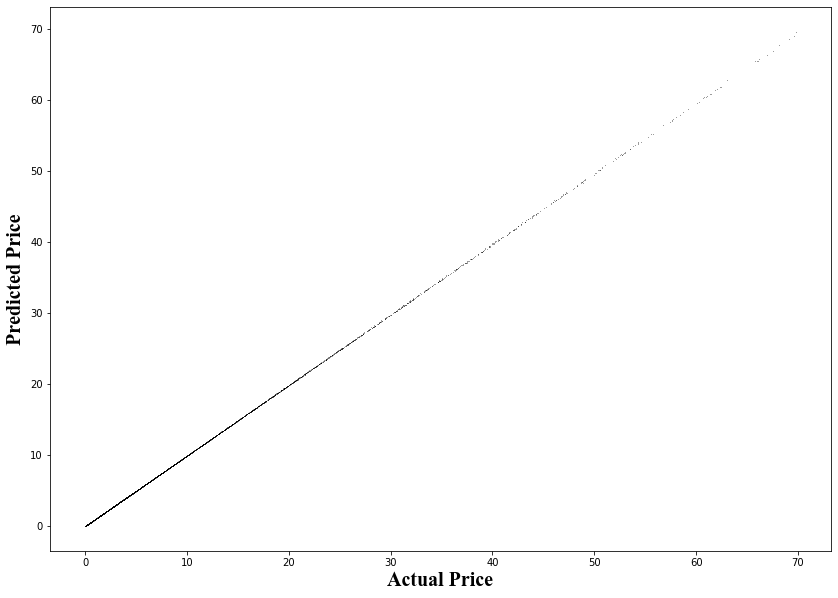

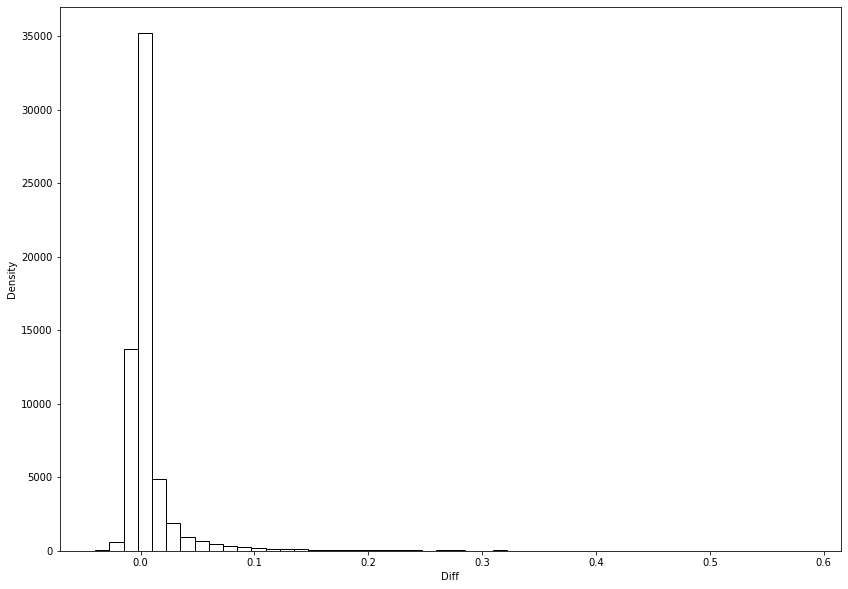

In [27]:
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
CheckAccuracy(y_test, y_test_hat)

Loaded model from disk
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 64)                384       
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 126)               8190      
_________________________________________________________________
activation_85 (Activation)   (None, 126)               0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 126)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 256)               32512     
_________________________________________________________________
activation_86 (Activation)   (

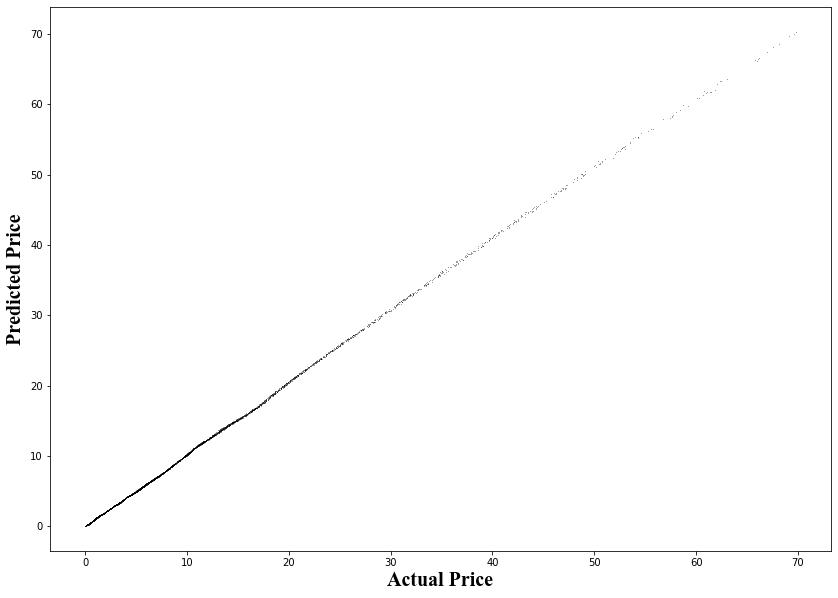

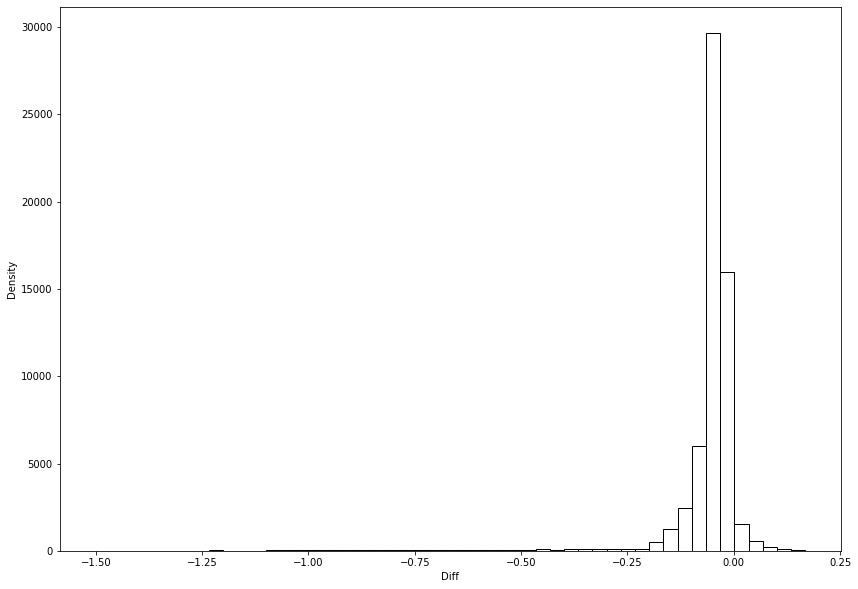

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")
loaded_model.summary()

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %f" % (loaded_model.metrics_names[1], score[0]))
model = loaded_model
y_test_hat = model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
CheckAccuracy(y_test, y_test_hat)

In [36]:
def DL_prediction(model, df):
    df['stock_price'] = df['stock_price']/df['strike_price']
    df['call_price'] = df['call_price']/df['strike_price']
    greek_input = df[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    nn_original_price = model.predict(greek_input)[0][0] 
    return nn_original_price

def DL_Greeks(model, df):
    
    time_mc_start = timer()
    
#The Greeks for DL model
#why it's forever negative, problem is my saving variables for Python!!

    change_stock_price = 0.1
    original_price = DL_prediction(model, df)
    bs_price = df['call_price'].values * df['strike_price'].values
    print('percentage error: ', (abs(bs_price - (original_price * df['strike_price'].values)))/bs_price, '%')
    
    df['stock_price'] = (df['stock_price']*df['strike_price'] + change_stock_price)/df['strike_price']
    greek_input = df[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_plus = model.predict(greek_input)[0][0] 

    df['stock_price'] = (df['stock_price']*df['strike_price'] - 2*change_stock_price)/df['strike_price']
    greek_input = df[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_minus = model.predict(greek_input)[0][0] 
    df['stock_price'] = (df['stock_price']*df['strike_price'] + change_stock_price)/df['strike_price']

    dl_delta = (p_plus - p_minus) / (2*change_stock_price)
    dl_gamma = (p_plus - 2*original_price + p_minus) /(change_stock_price*change_stock_price)

    print("delta in MC is: ", dl_delta)
    print("gamma in MC is: ", dl_gamma)

    change_r = 0.001
    df['risk_free_rate'] = df['risk_free_rate'] + change_r
    greek_input = df[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_plus = model.predict(greek_input)[0][0] 
    df['risk_free_rate'] = df['risk_free_rate'] - change_r
    dl_rho = (p_plus - original_price) / change_r
    print("rho in MC is: ", dl_rho)

    change_sigma = 0.001
    df['volatility'] = df['volatility'] + change_sigma
    greek_input = df[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_plus = model.predict(greek_input)[0][0] 
    df['volatility'] = df['volatility'] - change_sigma
    dl_vega = (p_plus - original_price) / change_sigma
    print("vega in MC is: ", dl_vega)

    change_in_time = 1.0 / 365
    df['maturity'] = df['maturity'] + change_in_time
    greek_input = df[['stock_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    p_later = model.predict(greek_input)[0][0] 
    dl_theta = (p_later - original_price) / change_in_time
    print("theta in MC is: ", dl_theta)

    time_mc_end = timer()
    time_mc = time_mc_end - time_mc_start

    print("Time used for MC calculation in total is ", time_mc, ' seconds')

option = random_options(1)
dataframe = pd.DataFrame([option[0].data_set()])
dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']

print('Option Price with BSM: ',option[0].BSM_price())
print('Option Price with MC and normal random number: ',option[0].MC_price())
print('Option Price with MC and antithetic variates and moment matching: ',option[0].MC_A_price())
print('Option Price with DL: ',DL_prediction(model, dataframe) * dataframe['strike_price'].values )
print('-' * 80)
option[0].BSM_Greeks()
print('-' * 80)
option[0].MC_A_Greeks()
print('-' * 80)
DL_Greeks(model, dataframe)

Option Price with BSM:  12.73116713824793
Option Price with MC and normal random number:  12.892339549053101
Option Price with MC and antithetic variates and moment matching:  12.757314315291064
Option Price with DL:  [11.84676066]
--------------------------------------------------------------------------------
Delta is  0.21057511399903847
Gamma is  0.0020543608850685283
Tho is  27.61262296564977
Vega is  57.52777218951332
Theta is  -24.585112036296092
Time used for BS calculation in total is  2.3022999812383205e-05  seconds
--------------------------------------------------------------------------------
delta in MC is:  0.2105950611720342
gamma in MC is:  0.0020954271461093295
rho in MC is:  27.613553011395453
vega in MC is:  57.64515161214412
theta in MC is:  -24.612709965086495
Time used for MC calculation in total is  0.2695920579999438  seconds
--------------------------------------------------------------------------------
percentage error:  [14.36933861] %
delta in MC is:  3.82

Load pre-trained model from hyper-parameter optimization scripts